Thư viện

In [21]:
%pip install torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

Device: cuda


ViT


**Step 1: Patch Embedding**

In [23]:
class patch_embedding(nn.Module):
    def __init__(self, colors=3, embed_dim=128, patch_size=4):
        super().__init__()
        self.patch = nn.Conv2d(in_channels=colors, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self,x):
        x = self.patch(x)
        x = x.flatten(2) #[Batch,128,8,8] -> [Batch,128,64]
        x = x.transpose(1,2) #[Batch,64,128]
        return x

Ảnh gốc: torch.Size([128, 3, 32, 32])
Sau patch embedding: torch.Size([128, 64, 128])


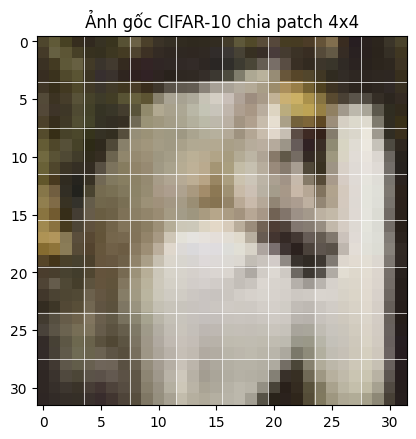

In [24]:
#visualization
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)

patch_embed = patch_embedding().to(device)
out = patch_embed(imgs)

print("Ảnh gốc:", imgs.shape)
print("Sau patch embedding:", out.shape)

import matplotlib.pyplot as plt
import numpy as np

img = imgs[0].cpu().permute(1,2,0).numpy()
plt.imshow((img * 0.5) + 0.5)
plt.title("Ảnh gốc CIFAR-10 chia patch 4x4")
for i in range(0, 32, 4):
    plt.axhline(i - 0.5, color='white', linewidth=0.5)
for j in range(0, 32, 4):
    plt.axvline(j - 0.5, color='white', linewidth=0.5)
plt.show()


**Step 2: Positional Encoding**

In [25]:
class positional_embedding(nn.Module):
    def __init__(self, embed_dim, num_patch):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patch + 1, embed_dim))
    def forward(self, x):
        return x + self.pos_embed

**Step 3: Transformer Encoder**

In [ ]:
class multi_head_self_attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        out, _ = self.attention(x, x, x)
        return out

In [ ]:
class transformer_encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        #Layer 1
        self.norm1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = multi_head_self_attention(embed_dim, num_heads)
        #Layer 2
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.LeakyReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
    def forward(self, x):
        x = x + self.multi_head_attention   (self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

**Step 4: Vision Transformer**


In [28]:
class vision_transformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=128, depth=6, num_heads=8, mlp_dim=256):
        super().__init__()
        self.patch_embed = patch_embedding(in_chans, embed_dim, patch_size)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.pos_embed = positional_embedding(embed_dim, num_patches)

        self.encoders = nn.ModuleList([
            transformer_encoder(embed_dim, num_heads, mlp_dim)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)               # [B, 64, 128]
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, 128]
        x = torch.cat((cls_token, x), dim=1)           # [B, 65, 128]
        x = self.pos_embed(x)

        for blk in self.encoders:
            x = blk(x)

        x = self.norm(x)
        cls_out = x[:, 0]  # lấy token đầu tiên
        out = self.head(cls_out)
        return out

In [29]:
# ================== Training Loop ==================
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, 100 * correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, 100 * correct / total

# ================== Main Train ==================
model = vision_transformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

epochs = 10
best_acc = 0.0
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion)
    print(f"Train loss {train_loss:.4f}, acc {train_acc:.2f}% | Val loss {val_loss:.4f}, acc {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit.pth")
        print("✅ Saved best model.")

print(f"\nBest Validation Accuracy: {best_acc:.2f}%")


Epoch 1/10


Train loss 2.3135, acc 9.84% | Val loss 2.3119, acc 10.00%
✅ Saved best model.

Epoch 2/10


Train loss 2.3082, acc 9.99% | Val loss 2.3090, acc 10.00%

Epoch 3/10


Train loss 2.3075, acc 9.88% | Val loss 2.3069, acc 10.00%

Epoch 4/10


Train loss 2.3070, acc 9.99% | Val loss 2.3068, acc 10.00%

Epoch 5/10


Train loss 2.3064, acc 9.92% | Val loss 2.3045, acc 10.00%

Epoch 6/10


Train loss 2.3063, acc 9.77% | Val loss 2.3081, acc 10.00%

Epoch 7/10


Train loss 2.3061, acc 9.78% | Val loss 2.3045, acc 10.00%

Epoch 8/10


Train loss 2.3062, acc 9.88% | Val loss 2.3040, acc 10.00%

Epoch 9/10


Train loss 2.3054, acc 10.11% | Val loss 2.3054, acc 10.00%

Epoch 10/10


Train loss 2.3054, acc 9.78% | Val loss 2.3056, acc 10.00%

Best Validation Accuracy: 10.00%
